In [1]:
library(data.table)
library(tidyverse)
library(DESeq2)
library(rtracklayer)
library(dplyr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::quarter()
✖ lubridate::second()  masks data.table::second()
✖ purrr::transpose()   masks data.table::transpose()
✖ lubridate::wday() 

This script is run to make the plot of the isocromosome 7 between D0 and Q1: before we run basic Deseq2 analysis. The Deseq2 analysis for all samples can be found in the other script!

In [ ]:
path_barcodes <- file.path("/barcodes_tumour_cells_D0.tsv")

# Get the list of files in the directory, including their full paths
barcodes <- read.delim(path_barcodes, header = FALSE)

In [4]:
barcodes$V1 <- gsub("-D0","",barcodes$V1)

# Load in the Raw counts form D0

In [ ]:
raw_counts_D0 <- read.table("/isoquant/D0.gene_counts.tsv", header =1)
head(raw_counts_D0)

,feature_id,AAACAGCCAGTTTGTG,AAACAGCCATGTTTGG,AAACAGCCATTTAAGC,AAACATGCATTGGGAG,AAACCAACAATAACCT,AAACCGAAGAGCCGCT,AAACCGAAGTAACCAC,AAACCGGCAAACTGCC,AAACGCGCACTAGCGT,⋯,TTTGGTGCATAAAGCA,TTTGTCCCAAACCCTA,TTTGTCCCAATAGCAA,TTTGTCCCACTTCACT,TTTGTCCCATGTGGGA,TTTGTCTAGACAAGTG,TTTGTCTAGCTCATAA,TTTGTCTAGGTCGAGG,TTTGTTGGTAACCAGC,TTTGTTGGTAGCAGCT
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000000457,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,ENSG00000000460,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,ENSG00000000938,0,0,0,0,0,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0
4,ENSG00000000971,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,ENSG00000001460,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,ENSG00000001461,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [7]:
D0 <- barcodes

In [8]:
count <- raw_counts_D0 %>% dplyr::select(which(colnames(raw_counts_D0) %in% D0$V1))

# Code for filter tumour cells based on barcodes and create pseudobulk by summinng rows

In [9]:
process_raw_counts <- function(raw_counts, D0) {
  # Set row names and remove the first column
  rownames(raw_counts) <- raw_counts$feature_id
  raw_counts <- raw_counts[, -1]
  
  # Remove columns that match `D0_V1`
  raw_counts <- raw_counts %>%
    dplyr::select(which(colnames(raw_counts) %in% D0$V1))
  
  # Add a new column `D0` with row sums
  raw_counts$D0 <- rowSums(raw_counts)
  
  # Return a data frame with only the `D0` column
  D0 <- raw_counts %>% select(D0)
  return(D0)
}


# Same for Q1

In [ ]:
raw_count_Q1 <- read.table("/isoquant/Q1.gene_counts.tsv", header =1)
#Cropt the barcodes of the tag
path_barcodes <- file.path("/barcodes_tumour_cells_Q1.tsv")

# Get the list of files in the directory, including their full paths
barcodes <- read.delim(path_barcodes, header = FALSE)
barcodes$V1 <- gsub("-Q1","",barcodes$V1)
Q1 <-barcodes


In [11]:
head(raw_count_Q1)

,feature_id,AAACAGCCAACATAAG,AAACAGCCATGTTGGC,AAACATGCACCGGCTA,AAACATGCACTTAACG,AAACATGCATTGTGCA,AAACCAACAAATACCT,AAACCAACAAGGTAAC,AAACCAACATAGACTT,AAACCGAAGCCTGACA,⋯,TTTGTCCCATTGTGTG,TTTGTCTAGTCCTTTG,TTTGTGAAGCATGGTT,TTTGTGAAGGTTAGAG,TTTGTGGCAAAGCGCA,TTTGTGGCAGGAACTG,TTTGTGTTCAGGCCTA,TTTGTGTTCATTGTTC,TTTGTGTTCCGTTATT,TTTGTGTTCTAATCCT
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000000457,0,0,0,0,0,0,0,0,0,⋯,1,0,0,0,0,0,2,0,0,0
2,ENSG00000000460,0,0,0,0,0,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0
3,ENSG00000000938,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,ENSG00000000971,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,ENSG00000001460,0,0,0,0,0,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0
6,ENSG00000001461,3,0,0,2,0,0,0,0,0,⋯,5,0,0,0,0,0,0,0,0,0


# Code to split the single data into random datasets

In [12]:
# Function to divide the single cell dataframe in 5 random frames:
split_into_groups <- function(df, num_groups = 5, seed =123){
    barcode_cols <- setdiff(names(df), "feature_id") # I want all the barcodes but not feature_id
    set.seed(seed)

    barcode_cols <- sample(barcode_cols) #shuffle the barcodes to create random sets

    group_size <- ceiling(length(barcode_cols) / num_groups) #Split into groups
    groups <- split(barcode_cols, ceiling(1:length(barcode_cols) / group_size)) #Now make the groups

    grouped_dfs <- lapply(groups, function(cols) df[, c("feature_id", cols)]) #Make a data.table out of it

    return(grouped_dfs)   
}

In [13]:
grouped_data_D0 <- split_into_groups(raw_counts_D0, num_groups = 3, seed=123)

In [14]:
D0_bulk <- lapply(names(grouped_data_D0), function(sample_name) {
  # Get the corresponding group (x) from 'grouped_data_D0'
  x <- grouped_data_D0[[sample_name]]
  processed <- process_raw_counts(x, D0)
  
  colnames(processed) <- paste0("D0_", sample_name)
  
  return(processed)
})


In [16]:
grouped_data_Q1 <- split_into_groups(raw_count_Q1, num_groups = 3, seed=123)
Q1_bulk <- lapply(names(grouped_data_Q1), function(sample_name) {
  # Get the corresponding group (x) from 'grouped_data_D0'
  x <- grouped_data_Q1[[sample_name]]
    processed <- process_raw_counts(x, Q1)
  
    colnames(processed) <- paste0("Q1_", sample_name)
  
  return(processed)
})

In [17]:
for (i in 1:length(D0_bulk)) {
  var_name <- paste0("D0_", i)
  
  # Assign the data frame to the variable name
  assign(var_name, D0_bulk[[i]])
  df <- get(var_name)  # Get the data frame by its dynamically created name
  df <- rownames_to_column(df, var = "Row.names")  # Convert row names to column
  
  # Re-assign the modified data frame back to the variable
  assign(var_name, df)
}

In [18]:
for (i in 1:length(Q1_bulk)) {
  var_name <- paste0("Q1_", i)
  
  # Assign the data frame to the variable name
  assign(var_name, Q1_bulk[[i]])
  df <- get(var_name)  # Get the data frame by its dynamically created name
  df <- rownames_to_column(df, var = "Row.names")  # Convert row names to column
  
  # Re-assign the modified data frame back to the variable
  assign(var_name, df)
}

In [19]:
bulk_D0_Q1 <- Reduce(function(x, y) merge(x, y, by = "Row.names"),
               list(D0_1, D0_2,D0_3 ,Q1_1, Q1_2, Q1_3))

rownames(bulk_D0_Q1 ) <- bulk_D0_Q1$Row.names
bulk_D0_Q1  <- bulk_D0_Q1 [, -1]

# Created bulk for D0 vs Q1

In [20]:
bulk_D0_Q1

,D0_1,D0_2,D0_3,Q1_1,Q1_2,Q1_3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003,23.0,17.0,8,7.0,9.0,5.0
ENSG00000000005,0.0,0.0,0,0.0,0.0,0.0
ENSG00000000419,207.0,242.0,214,262.0,285.0,273.0
ENSG00000000457,36.0,54.5,54,66.5,77.0,55.0
ENSG00000000460,42.0,46.5,33,42.5,50.0,60.0
ENSG00000000938,25.0,8.0,5,13.0,14.0,9.0
ENSG00000000971,0.0,0.0,0,0.0,0.0,0.0
ENSG00000001036,28.0,13.0,9,20.0,24.0,15.0
ENSG00000001084,111.0,58.0,89,70.0,82.0,76.0


In [21]:
bulk_D0_Q1 <- bulk_D0_Q1[, c("Q1_1", "Q1_2", "Q1_3", "D0_1", "D0_2", "D0_3")]

In [22]:
# Define samples and conditions
samples <- colnames(bulk_D0_Q1)
condition <- c("treated", "treated", "treated", 
               "untreated", "untreated", "untreated")

# Create the coldata data frame (without duplicate row names)
coldata <- data.frame(sample = samples, condition = condition, row.names = samples)

# View the data frame
print(coldata)


     sample condition
Q1_1   Q1_1   treated
Q1_2   Q1_2   treated
Q1_3   Q1_3   treated
D0_1   D0_1 untreated
D0_2   D0_2 untreated
D0_3   D0_3 untreated


In [23]:
bulk_D0_Q1 <- as.matrix(bulk_D0_Q1)
bulk_D0_Q1[] <- as.integer(bulk_D0_Q1)

In [24]:
dds <- DESeqDataSetFromMatrix(countData = bulk_D0_Q1,
                              colData = coldata,
                              design = ~ condition)
dds

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 36601 6 
metadata(1): version
assays(1): counts
rownames(36601): ENSG00000000003 ENSG00000000005 ... ENSG00000288459
  ENSG00000288460
rowData names(0):
colnames(6): Q1_1 Q1_2 ... D0_2 D0_3
colData names(2): sample condition

In [25]:
#Pre-filtering:
# If the counts it smaller tham 10 in all samples than filter out
#smallestGroupSize = 4, you're saying that a gene must have counts greater than or equal to 10 in at least 4 samples in order to be kept.
#So set to 1 first
keep <- rowSums(counts(dds) >= 10) >= 1
dds <- dds[keep,]
dds

class: DESeqDataSet 
dim: 16192 6 
metadata(1): version
assays(1): counts
rownames(16192): ENSG00000000003 ENSG00000000419 ... ENSG00000288380
  ENSG00000288398
rowData names(0):
colnames(6): Q1_1 Q1_2 ... D0_2 D0_3
colData names(2): sample condition

In [26]:
dds$condition <- relevel(dds$condition, ref = "untreated")
dds <- DESeq(dds)
res <- results(dds, contrast=c("condition", "treated", "untreated"), alpha=0.05)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [ ]:
GFFfile <- readGFF("/gencode.v43.basic.annotation.gtf")

In [28]:
GFFfile <- GFFfile %>% select(gene_name, gene_id)
GFFfile <- GFFfile %>%
  mutate(gene_id = sapply(str_split(gene_id, "\\."), function(x) x[1]))
GFFfile <- GFFfile[!duplicated(GFFfile$gene_name), ]
head(GFFfile)

,gene_name,gene_id
,<chr>,<chr>
1,DDX11L2,ENSG00000290825
6,DDX11L1,ENSG00000223972
14,WASH7P,ENSG00000227232
27,MIR6859-1,ENSG00000278267
30,MIR1302-2HG,ENSG00000243485
38,MIR1302-2,ENSG00000284332


In [29]:
res_df <- merge(as.data.frame(res), GFFfile, by.x = "row.names", by.y="gene_id")
res_df

Row.names,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000000003,12.026017,-1.54704471,0.62256050,-2.48497087,1.295620e-02,4.051503e-02,TSPAN6
ENSG00000000419,243.618064,-0.05101503,0.12854991,-0.39684998,6.914781e-01,8.108055e-01,DPM1
ENSG00000000457,55.856464,0.10214577,0.27934454,0.36566229,7.146171e-01,8.275105e-01,SCYL3
ENSG00000000460,44.766758,-0.02871300,0.30178069,-0.09514526,9.241995e-01,9.587185e-01,C1orf112
ENSG00000000938,12.357012,-0.43325983,0.63608149,-0.68113887,4.957836e-01,6.543214e-01,FGR
ENSG00000001036,17.960175,-0.11671236,0.50989946,-0.22889289,8.189522e-01,8.942257e-01,FUCA2
ENSG00000001084,81.584496,-0.53755478,0.24864165,-2.16196592,3.062080e-02,8.227880e-02,GCLC
ENSG00000001167,138.720714,-0.25118840,0.16687665,-1.50523390,1.322640e-01,2.586495e-01,NFYA
ENSG00000001460,13.584536,-1.06601277,0.67054650,-1.58976712,1.118873e-01,2.279415e-01,STPG1


In [30]:
resultsNames(dds)
resLFC <- lfcShrink(dds, coef="condition_treated_vs_untreated", type="apeglm")
resLFC

[1] "Intercept"                      "condition_treated_vs_untreated"

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



log2 fold change (MAP): condition treated vs untreated 
Wald test p-value: condition treated vs untreated 
DataFrame with 16192 rows and 5 columns
                 baseMean log2FoldChange     lfcSE      pvalue        padj
                <numeric>      <numeric> <numeric>   <numeric>   <numeric>
ENSG00000000003   12.0260     -1.0092154  0.699623   0.0129562    0.040515
ENSG00000000419  243.6181     -0.0472627  0.123951   0.6914781    0.810806
ENSG00000000457   55.8565      0.0756094  0.240556   0.7146171    0.827511
ENSG00000000460   44.7668     -0.0197966  0.253072   0.9241995    0.958719
ENSG00000000938   12.3570     -0.1552376  0.395407   0.4957836    0.654321
...                   ...            ...       ...         ...         ...
ENSG00000288156  32.34589      -0.180286  0.322242 4.46775e-01 6.12444e-01
ENSG00000288162   6.41218       5.978441  2.530707 1.47014e-05 1.10513e-04
ENSG00000288302 165.15507       0.909015  0.158487 2.04873e-09 3.10319e-08
ENSG00000288380  80.26448   

In [31]:
resOrdered <- res[order(res$pvalue),]
resOrdered_df <- merge(as.data.frame(resOrdered), GFFfile, by.x = "row.names", by.y="gene_id")
resOrdered_df <- resOrdered_df[order(resOrdered_df$padj),]
resOrdered_df

,Row.names,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
167,ENSG00000008988,15911.7029,0.8736037,0.01997269,43.73991,0.000000e+00,0.000000e+00,RPS20
883,ENSG00000071082,15789.8437,0.9120215,0.02195469,41.54107,0.000000e+00,0.000000e+00,RPL31
2467,ENSG00000106211,3989.5391,2.2794300,0.04040489,56.41471,0.000000e+00,0.000000e+00,HSPB1
3043,ENSG00000112306,39592.7193,1.0082457,0.01649306,61.13152,0.000000e+00,0.000000e+00,RPS12
4925,ENSG00000133112,16816.4541,0.8094644,0.02093642,38.66298,0.000000e+00,0.000000e+00,TPT1
5514,ENSG00000137818,43663.0893,0.8955089,0.01689063,53.01810,0.000000e+00,0.000000e+00,RPLP1
5577,ENSG00000138326,23164.0419,0.7275472,0.01749415,41.58803,0.000000e+00,0.000000e+00,RPS24
6057,ENSG00000142937,14740.3644,0.7802394,0.01999334,39.02497,0.000000e+00,0.000000e+00,RPS8
6340,ENSG00000145425,18045.4473,0.7329901,0.01868972,39.21889,0.000000e+00,0.000000e+00,RPS3A


In [32]:
summary(res)


out of 16192 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2884, 18%
LFC < 0 (down)     : 2498, 15%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [33]:
sum(res$padj < 0.05, na.rm=TRUE)

[1] 5382

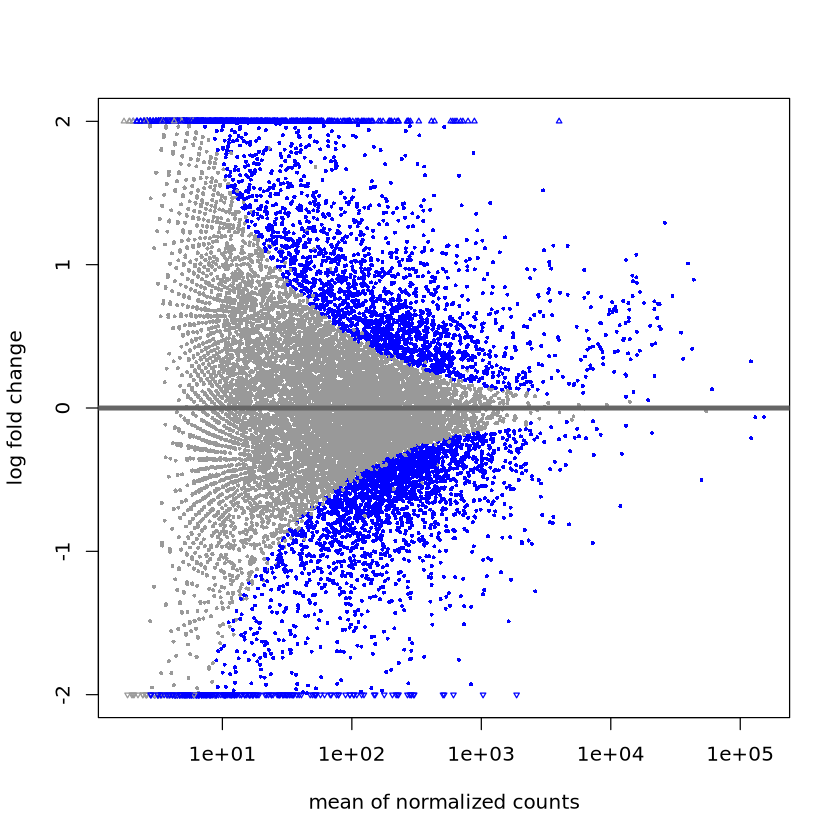

In [34]:
par(bg = "white")

# Plot the MA plot with specified y-axis limits
plotMA(res, ylim=c(-2, 2))

# Reset par to default if needed
par(bg = "transparent")

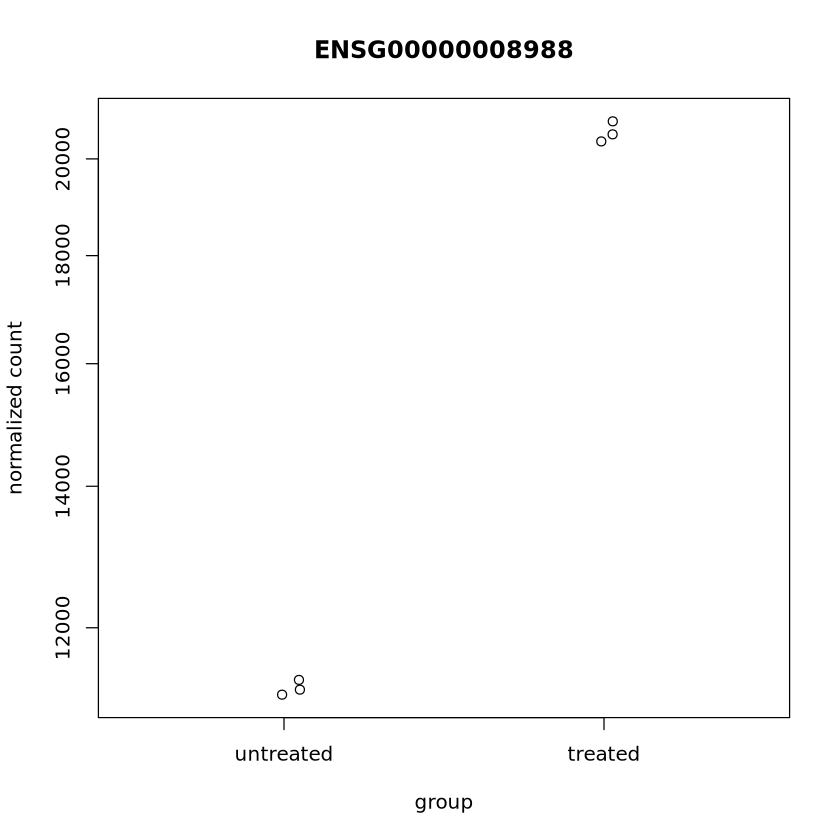

In [35]:
par(bg = "white")
plotCounts(dds, gene=which.min(res$padj), intgroup="condition")

In [36]:
rownames(res) <- sapply(rownames(res), function(x) {
  match_idx <- match(x, GFFfile$gene_id)
  if (!is.na(match_idx)) {
    return(GFFfile$gene_name[match_idx])
  } else {
    return(x)  # Keep original rowname if no match
  }
})

# View the updated `res`
print(res)

log2 fold change (MLE): condition treated vs untreated 
Wald test p-value: condition treated vs untreated 
DataFrame with 16192 rows and 6 columns
                 baseMean log2FoldChange     lfcSE       stat      pvalue
                <numeric>      <numeric> <numeric>  <numeric>   <numeric>
TSPAN6            12.0260      -1.547045  0.622561 -2.4849709   0.0129562
DPM1             243.6181      -0.051015  0.128550 -0.3968500   0.6914781
SCYL3             55.8565       0.102146  0.279345  0.3656623   0.7146171
C1orf112          44.7668      -0.028713  0.301781 -0.0951453   0.9241995
FGR               12.3570      -0.433260  0.636081 -0.6811389   0.4957836
...                   ...            ...       ...        ...         ...
ENSG00000288156  32.34589      -0.312659  0.410960  -0.760802 4.46775e-01
ENSG00000288162   6.41218       5.957512  1.374880   4.333115 1.47014e-05
ENSG00000288302 165.15507       0.944813  0.157629   5.993895 2.04873e-09
ENSG00000288380  80.26448       0.66007

In [37]:
library(EnhancedVolcano)
library(pheatmap)

Loading required package: ggrepel



In [ ]:
setwd("/output_figures")

In [45]:
#Circos Plot
library(biomaRt)

In [46]:
ensembl <- useEnsembl(biomart = "genes")

In [47]:
datasets = listDatasets(ensembl)

In [48]:
head(datasets)

,dataset,description,version
,<I<chr>>,<I<chr>>,<I<chr>>
1,abrachyrhynchus_gene_ensembl,Pink-footed goose genes (ASM259213v1),ASM259213v1
2,acalliptera_gene_ensembl,Eastern happy genes (fAstCal1.3),fAstCal1.3
3,acarolinensis_gene_ensembl,Green anole genes (AnoCar2.0v2),AnoCar2.0v2
4,acchrysaetos_gene_ensembl,Golden eagle genes (bAquChr1.2),bAquChr1.2
5,acitrinellus_gene_ensembl,Midas cichlid genes (Midas_v5),Midas_v5
6,amelanoleuca_gene_ensembl,Giant panda genes (ASM200744v2),ASM200744v2


In [49]:
dataset_nb = grep("human", datasets$description, ignore.case = TRUE)
dataset = datasets$dataset[dataset_nb]

In [50]:
ensembl <- useDataset(dataset = dataset, mart=ensembl)

In [51]:
# Get coordinates for all genes:
attributes <- c("ensembl_gene_id", "chromosome_name", "start_position", "end_position")
values <- list(ensembl_gene_id=c())
all.genes <- getBM(attributes=attributes, values = values, mart = ensembl)
head(all.genes)

,ensembl_gene_id,chromosome_name,start_position,end_position
,<chr>,<chr>,<int>,<int>
1,ENSG00000210049,MT,577,647
2,ENSG00000211459,MT,648,1601
3,ENSG00000210077,MT,1602,1670
4,ENSG00000210082,MT,1671,3229
5,ENSG00000209082,MT,3230,3304
6,ENSG00000198888,MT,3307,4262


In [52]:
#Rename and match with the DEseq output:
colnames(all.genes)[1] = "Gene.ID"


In [53]:
head(res_df)

,Row.names,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,ENSG00000000003,12.02602,-1.54704471,0.6225605,-2.48497087,0.0129562,0.04051503,TSPAN6
2,ENSG00000000419,243.61806,-0.05101503,0.1285499,-0.39684998,0.6914781,0.81080551,DPM1
3,ENSG00000000457,55.85646,0.10214577,0.2793445,0.36566229,0.7146171,0.82751054,SCYL3
4,ENSG00000000460,44.76676,-0.02871300,0.3017807,-0.09514526,0.9241995,0.95871853,C1orf112
5,ENSG00000000938,12.35701,-0.43325983,0.6360815,-0.68113887,0.4957836,0.65432138,FGR
6,ENSG00000001036,17.96017,-0.11671236,0.5098995,-0.22889289,0.8189522,0.89422574,FUCA2


In [54]:
res_df$Gene.ID <- res_df$Row.names

In [55]:
merged_data <- merge(all.genes, res_df, by="Gene.ID")
head(merged_data)

,Gene.ID,chromosome_name,start_position,end_position,Row.names,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
,<chr>,<chr>,<int>,<int>,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,ENSG00000000003,X,100627108,100639991,ENSG00000000003,12.02602,-1.54704471,0.6225605,-2.48497087,0.0129562,0.04051503,TSPAN6
2,ENSG00000000419,20,50934867,50959140,ENSG00000000419,243.61806,-0.05101503,0.1285499,-0.39684998,0.6914781,0.81080551,DPM1
3,ENSG00000000457,1,169849631,169894267,ENSG00000000457,55.85646,0.10214577,0.2793445,0.36566229,0.7146171,0.82751054,SCYL3
4,ENSG00000000460,1,169662007,169854080,ENSG00000000460,44.76676,-0.02871300,0.3017807,-0.09514526,0.9241995,0.95871853,C1orf112
5,ENSG00000000938,1,27612064,27635185,ENSG00000000938,12.35701,-0.43325983,0.6360815,-0.68113887,0.4957836,0.65432138,FGR
6,ENSG00000001036,6,143494812,143511720,ENSG00000001036,17.96017,-0.11671236,0.5098995,-0.22889289,0.8189522,0.89422574,FUCA2


In [56]:
merged_data$chromosome_name <- paste("chr", merged_data$chromosome_name, sep = "")
head(merged_data)

,Gene.ID,chromosome_name,start_position,end_position,Row.names,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
,<chr>,<chr>,<int>,<int>,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,ENSG00000000003,chrX,100627108,100639991,ENSG00000000003,12.02602,-1.54704471,0.6225605,-2.48497087,0.0129562,0.04051503,TSPAN6
2,ENSG00000000419,chr20,50934867,50959140,ENSG00000000419,243.61806,-0.05101503,0.1285499,-0.39684998,0.6914781,0.81080551,DPM1
3,ENSG00000000457,chr1,169849631,169894267,ENSG00000000457,55.85646,0.10214577,0.2793445,0.36566229,0.7146171,0.82751054,SCYL3
4,ENSG00000000460,chr1,169662007,169854080,ENSG00000000460,44.76676,-0.02871300,0.3017807,-0.09514526,0.9241995,0.95871853,C1orf112
5,ENSG00000000938,chr1,27612064,27635185,ENSG00000000938,12.35701,-0.43325983,0.6360815,-0.68113887,0.4957836,0.65432138,FGR
6,ENSG00000001036,chr6,143494812,143511720,ENSG00000001036,17.96017,-0.11671236,0.5098995,-0.22889289,0.8189522,0.89422574,FUCA2


# Plotting expression per chromosome:

In [59]:
library("pasilla")
library("DESeq2")
library(ggrepel) 

Loading required package: DEXSeq

Loading required package: BiocParallel



Loading required package: AnnotationDbi


Attaching package: ‘AnnotationDbi’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: RColorBrewer



In [60]:
library(BSgenome.Hsapiens.UCSC.hg38)
library(GenomicRanges)

Loading required package: BSgenome

Loading required package: Biostrings

Loading required package: XVector


Attaching package: ‘XVector’


The following object is masked from ‘package:purrr’:

    compact



Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:

    strsplit


Loading required package: BiocIO


Attaching package: ‘BiocIO’


The following object is masked from ‘package:rtracklayer’:

    FileForFormat




In [62]:
cumdist <- setNames(object = c(0, cumsum(as.numeric(seqlengths(BSgenome.Hsapiens.UCSC.hg38)[1:22]))), nm = paste0("chr", 1:23))
head(cumdist)

chr1       chr2       chr3       chr4       chr5       chr6 
         0  248956422  491149951  689445510  879660065 1061198324

In [63]:
GR_data <- makeGRangesFromDataFrame(
  merged_data,
  seqnames.field = "chromosome_name",  # Column for chromosome names
  start.field = "start_position",     # Column for start positions
  end.field = "end_position",         # Column for end positions
  keep.extra.columns = TRUE           # Retain additional columns (e.g., log2FoldChange)
)

# Inspect the GenomicRanges object
GR_data

GRanges object with 15953 ranges and 9 metadata columns:
          seqnames              ranges strand |         Gene.ID       Row.names
             <Rle>           <IRanges>  <Rle> |     <character>          <AsIs>
      [1]     chrX 100627108-100639991      * | ENSG00000000003 ENSG00000000003
      [2]    chr20   50934867-50959140      * | ENSG00000000419 ENSG00000000419
      [3]     chr1 169849631-169894267      * | ENSG00000000457 ENSG00000000457
      [4]     chr1 169662007-169854080      * | ENSG00000000460 ENSG00000000460
      [5]     chr1   27612064-27635185      * | ENSG00000000938 ENSG00000000938
      ...      ...                 ...    ... .             ...             ...
  [15949]    chr11 111320379-111323816      * | ENSG00000288097 ENSG00000288097
  [15950]    chr19     2293173-2295781      * | ENSG00000288156 ENSG00000288156
  [15951]     chr6 170134257-170142926      * | ENSG00000288162 ENSG00000288162
  [15952]    chr14 101120512-101121577      * | ENSG00000288302

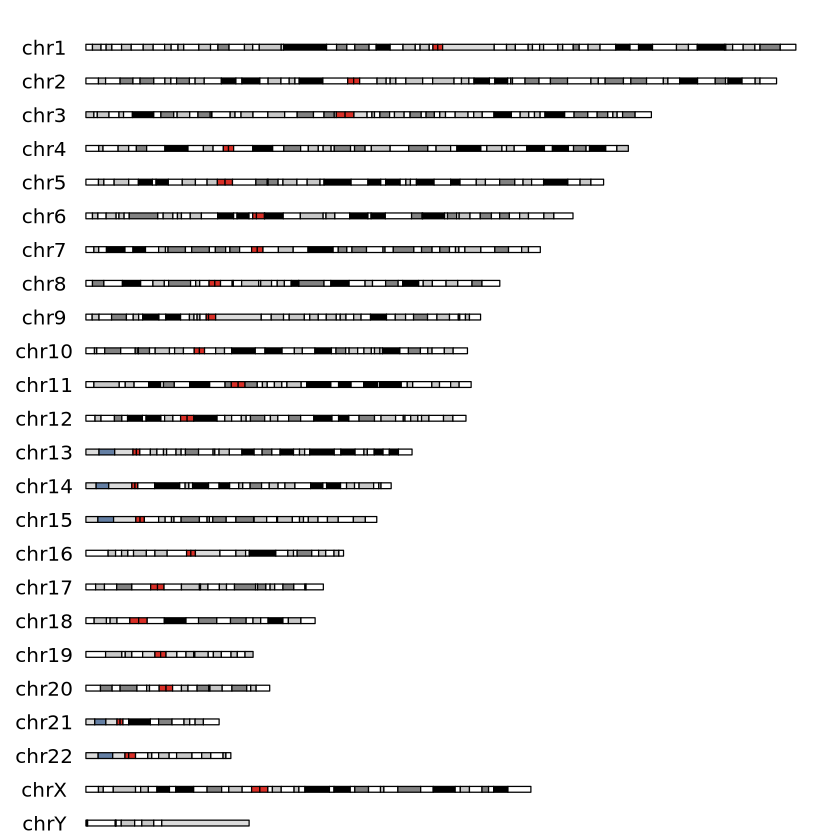

In [100]:
library(karyoploteR)
kp <- plotKaryotype(genome="hg38")


In [84]:
ordered <- GR_data[order(GR_data$padj, na.last = TRUE),]


In [101]:
dm.genes <- GR_data

In [86]:
filtered.dm.genes <- dm.genes[!is.na(dm.genes$padj)]
log.pval <- -log10(filtered.dm.genes$padj)
mcols(filtered.dm.genes)$log.pval <- log.pval
filtered.dm.genes

GRanges object with 15953 ranges and 10 metadata columns:
          seqnames              ranges strand |         Gene.ID       Row.names
             <Rle>           <IRanges>  <Rle> |     <character>          <AsIs>
      [1]     chrX 100627108-100639991      * | ENSG00000000003 ENSG00000000003
      [2]    chr20   50934867-50959140      * | ENSG00000000419 ENSG00000000419
      [3]     chr1 169849631-169894267      * | ENSG00000000457 ENSG00000000457
      [4]     chr1 169662007-169854080      * | ENSG00000000460 ENSG00000000460
      [5]     chr1   27612064-27635185      * | ENSG00000000938 ENSG00000000938
      ...      ...                 ...    ... .             ...             ...
  [15949]    chr11 111320379-111323816      * | ENSG00000288097 ENSG00000288097
  [15950]    chr19     2293173-2295781      * | ENSG00000288156 ENSG00000288156
  [15951]     chr6 170134257-170142926      * | ENSG00000288162 ENSG00000288162
  [15952]    chr14 101120512-101121577      * | ENSG0000028830

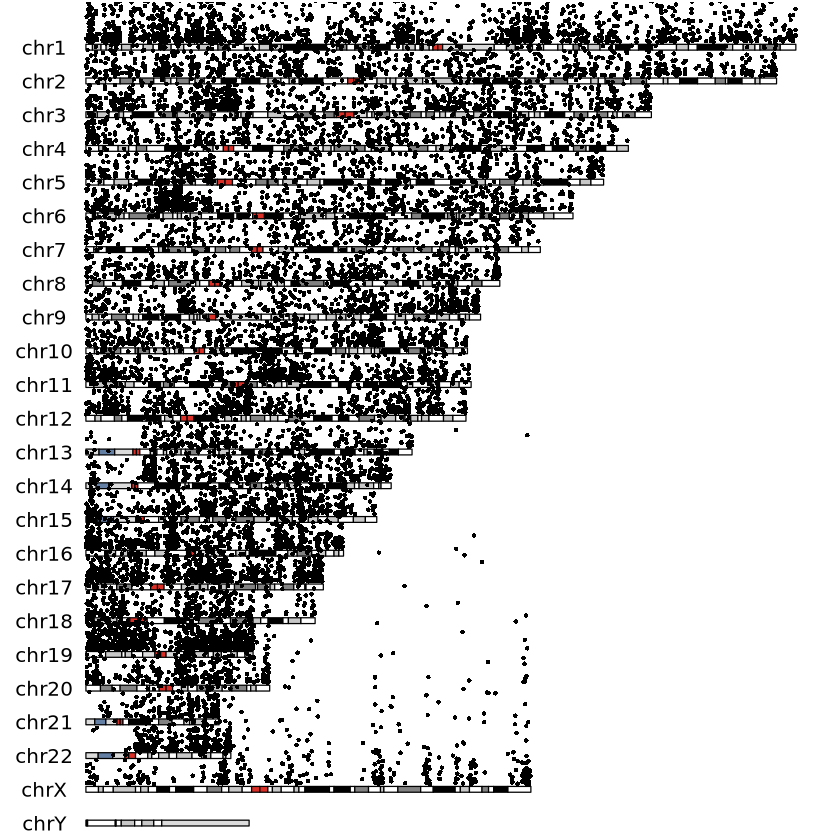

In [87]:
sign.genes <- filtered.dm.genes[filtered.dm.genes$padj < 5,] # so no filtering but we could also plot where padj < 0.05
kp <- plotKaryotype(genome="hg38")
kpPoints(kp, data=sign.genes, y=sign.genes$log.pval)

In [88]:
range(sign.genes$log.pval)

[1] 4.951808e-05          Inf

In [89]:
sum(sign.genes$log.pval == "Inf") 

[1] 16

In [90]:
sign.genes <- sign.genes[is.finite(sign.genes$log.pval), ]

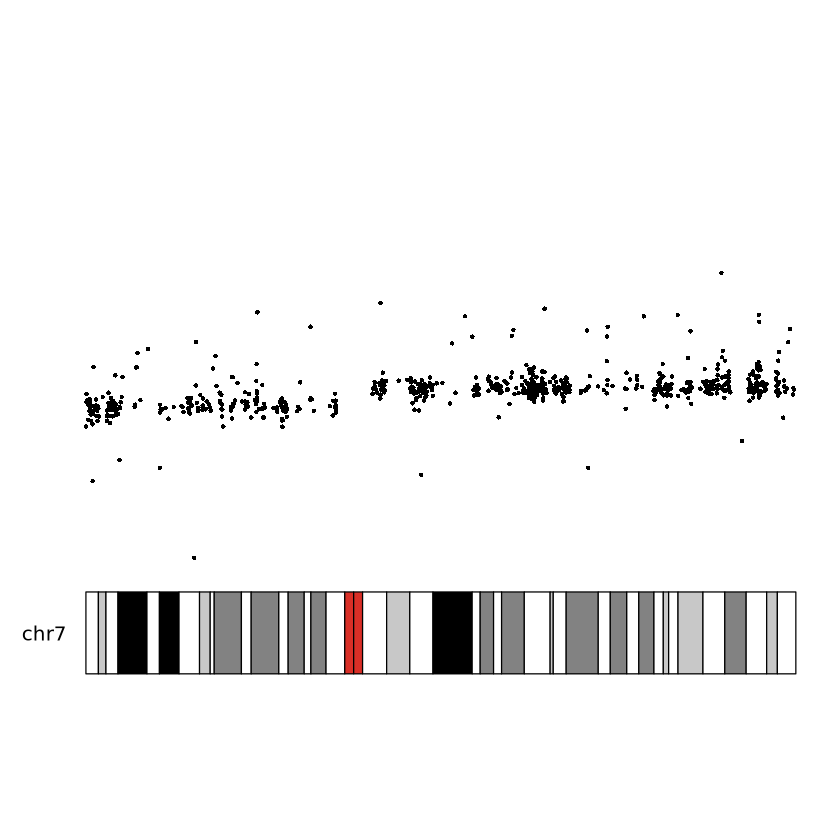

In [91]:
# Define Y-axis limits based on log2FoldChange values
fc.ymax <- ceiling(max(abs(sign.genes$log2FoldChange), na.rm = TRUE))
fc.ymin <- -fc.ymax

# Zoom in on chromosome 7
kp <- plotKaryotype(genome="hg38", chromosomes="chr7")

# Plot points
kpPoints(kp, data=sign.genes, y=sign.genes$log2FoldChange, ymax=fc.ymax, ymin=fc.ymin)

In [92]:
sign.genes <- sign.genes[abs(sign.genes$log2FoldChange) < 4.1,]

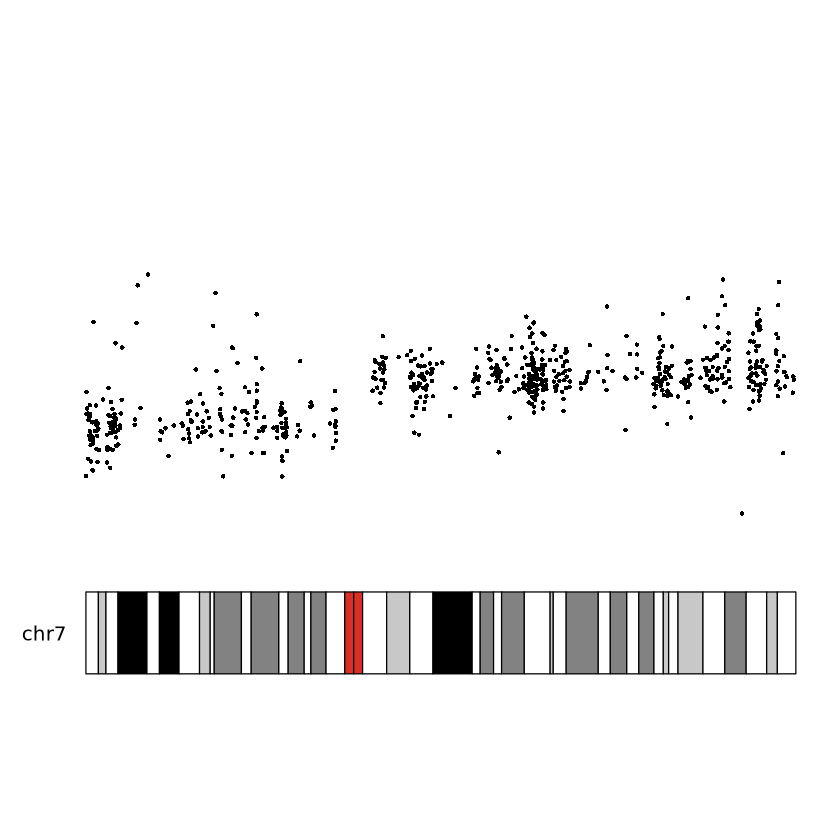

In [93]:
# Define Y-axis limits based on log2FoldChange values
fc.ymax <- ceiling(max(abs(sign.genes$log2FoldChange), na.rm = TRUE))
fc.ymin <- -fc.ymax

# Zoom in on chromosome 7
kp <- plotKaryotype(genome="hg38", chromosomes="chr7")

# Plot points
kpPoints(kp, data=sign.genes, y=sign.genes$log2FoldChange, ymax=fc.ymax, ymin=fc.ymin)

Warning message in text.default(x = x, y = y, labels = labels, pos = pos, offset = 0, :
""ymax" is not a graphical parameter"
Warning message in text.default(x = x, y = y, labels = labels, pos = pos, offset = 0, :
""ymin" is not a graphical parameter"


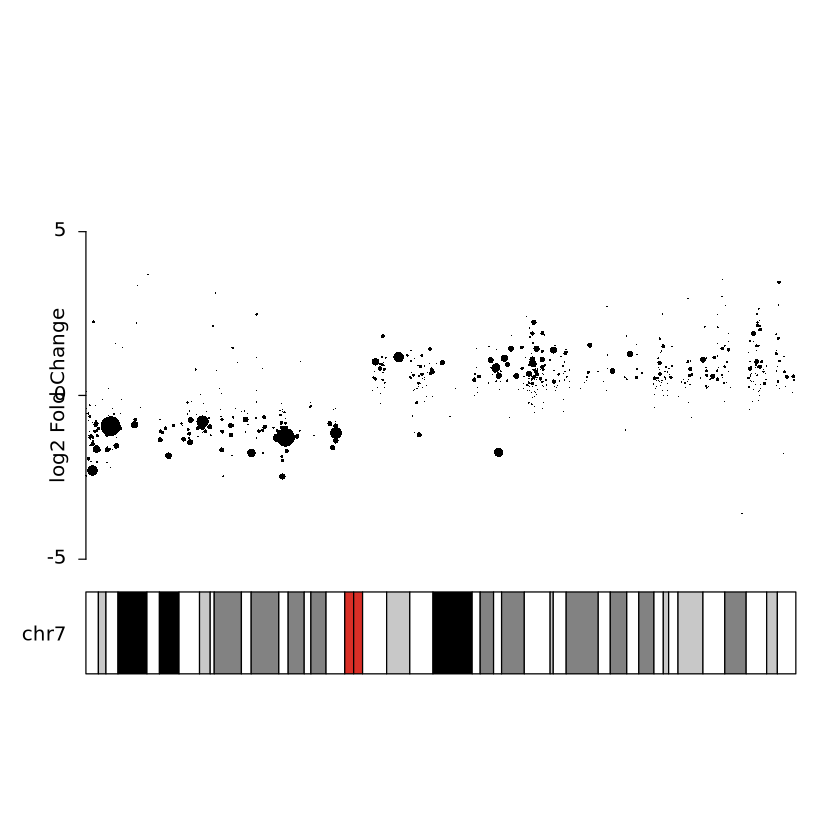

In [94]:
cex.val <- sqrt(sign.genes$log.pval)/7
kp <- plotKaryotype(genome="hg38", chromosomes = "chr7")
kpPoints(kp, data=sign.genes, y=sign.genes$log2FoldChange, cex=cex.val, ymax=fc.ymax, ymin=fc.ymin)
kpAxis(kp, ymax=fc.ymax, ymin=fc.ymin)
kpAddLabels(kp, labels = "log2 Fold Change", srt=90, pos=1, label.margin = 0.04, ymax=fc.ymax, ymin=fc.ymin)

Warning message in text.default(x = x, y = y, labels = labels, pos = pos, offset = 0, :
""ymax" is not a graphical parameter"
Warning message in text.default(x = x, y = y, labels = labels, pos = pos, offset = 0, :
""ymin" is not a graphical parameter"


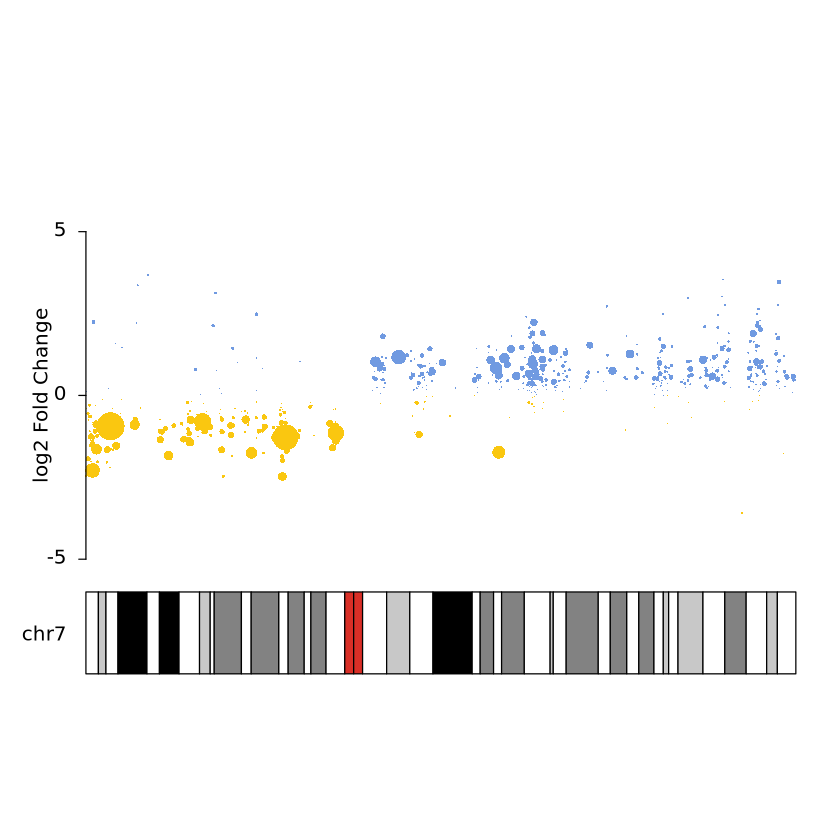

In [95]:
col.over <- "#709AE1FF"
col.under <- "#fac710"
sign.col <- rep(col.over, length(sign.genes))
sign.col[sign.genes$log2FoldChange<0] <- col.under
cex.val <- sqrt(sign.genes$log.pval)/5
kp <- plotKaryotype(genome="hg38", chromosomes = "chr7")
kpPoints(kp, data=sign.genes, y=sign.genes$log2FoldChange, cex=cex.val, ymax=fc.ymax, ymin=fc.ymin, col=sign.col)
kpAxis(kp, ymax=fc.ymax, ymin=fc.ymin)
kpAddLabels(kp, labels = "log2 Fold Change", srt=90, pos=1, label.margin = 0.06, ymax=fc.ymax, ymin=fc.ymin)

In [96]:
sign.genes <- sign.genes[abs(sign.genes$log2FoldChange) < 4.1,]

In [97]:
range(sign.genes$log2FoldChange)

[1] -4.053973  4.089793

Warning message in text.default(x = x, y = y, labels = labels, pos = pos, offset = 0, :
""ymax" is not a graphical parameter"
Warning message in text.default(x = x, y = y, labels = labels, pos = pos, offset = 0, :
""ymin" is not a graphical parameter"


$plot.params
$plot.params$leftmargin
[1] 0.1

$plot.params$rightmargin
[1] 0.05

$plot.params$topmargin
[1] 120

$plot.params$bottommargin
[1] 100

$plot.params$ideogramheight
[1] 50

$plot.params$ideogramlateralmargin
[1] 0

$plot.params$data1height
[1] 200

$plot.params$data1inmargin
[1] 20

$plot.params$data1outmargin
[1] 20

$plot.params$data1min
[1] 0

$plot.params$data1max
[1] 1

$plot.params$data2height
[1] 0

$plot.params$data2inmargin
[1] 0

$plot.params$data2outmargin
[1] 0

$plot.params$data2min
[1] 0

$plot.params$data2max
[1] 1

$plot.params$dataideogrammin
[1] 0

$plot.params$dataideogrammax
[1] 1

$plot.params$dataallmin
[1] 0

$plot.params$dataallmax
[1] 1


$genome.name
[1] "hg38"

$genome
GRanges object with 1 range and 0 metadata columns:
       seqnames      ranges strand
          <Rle>   <IRanges>  <Rle>
  chr7     chr7 1-159345973      *
  -------
  seqinfo: 1 sequence from hg38 genome

$cytobands
GRanges object with 44 ranges and 2 metadata columns:
       seqna

pdf 
  2

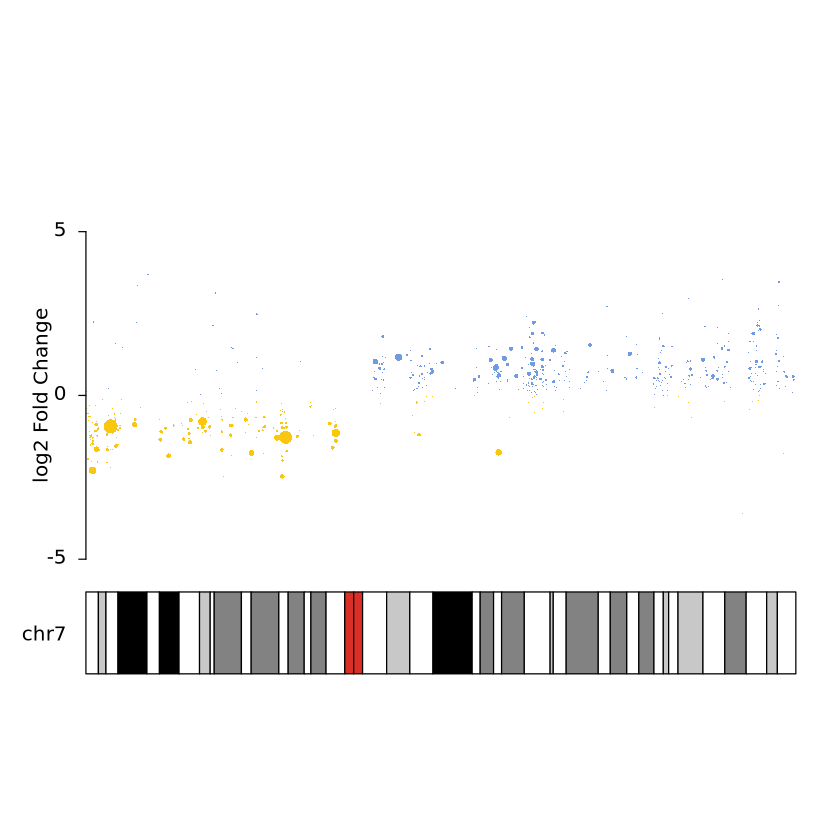

In [98]:
fc.ymax <- ceiling(max(abs(sign.genes$log2FoldChange), na.rm = TRUE))
fc.ymin <- -fc.ymax
col.over <- "#709AE1FF"
col.under <- "#fac710"
sign.col <- rep(col.over, length(sign.genes))
sign.col[sign.genes$log2FoldChange<0] <- col.under
cex.val <- sqrt(sign.genes$log.pval)/10
kp <- plotKaryotype(genome="hg38", chromosomes = "chr7")
kpPoints(kp, data=sign.genes, y=sign.genes$log2FoldChange, cex=cex.val, ymax=fc.ymax, ymin=fc.ymin, col=sign.col)
kpAxis(kp, ymax=fc.ymax, ymin=fc.ymin)
kpAddLabels(kp, labels = "log2 Fold Change", srt=90, pos=1, label.margin = 0.06, ymax=fc.ymax, ymin=fc.ymin)

pdf("Isochromosome.pdf", width = 8, height = 6)
print(kp)
dev.off()

In [ ]:
# Define the output directory and filename
output_dir <- "/Deseq2/"  # Change this to your desired folder
output_file <- paste0(output_dir, "chr7_log2FC_plot.pdf")

# Define plotting parameters
col.over <- "#709AE1FF"
col.under <- "#fac710"
sign.col <- rep(col.over, length(sign.genes))
sign.col[sign.genes$log2FoldChange<0] <- col.under

# Start PDF device
pdf("Isochromosome.pdf", width = 8, height = 6)

# All plotting must happen here
cex.val <- sqrt(sign.genes$log.pval)/5
kp <- plotKaryotype(genome="hg38", chromosomes = "chr7")
kpPoints(kp, data=sign.genes, y=sign.genes$log2FoldChange, cex=cex.val, ymax=fc.ymax, ymin=fc.ymin, col=sign.col)
kpAxis(kp, ymax=fc.ymax, ymin=fc.ymin)
kpAddLabels(kp, labels = "log2 Fold Change", srt=90, pos=1, label.margin = 0.06, ymax=fc.ymax, ymin=fc.ymin)

# Close the PDF device
dev.off()



Warning message in text.default(x = x, y = y, labels = labels, pos = pos, offset = 0, :
""ymax" is not a graphical parameter"
Warning message in text.default(x = x, y = y, labels = labels, pos = pos, offset = 0, :
""ymin" is not a graphical parameter"


pdf 
  2